In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, AveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet201
from keras.applications.xception import Xception
from keras.optimizers import Adam
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
import sys
import cv2

train_path='training_set_aligned/'
test_path='testing_set_aligned/'
valid_path='valid_set_aligned/'

img_height, img_width, img_channel = 299, 299, 3
batch_size = 16
aug_ratio = 1
epochs = 100

In [2]:
# -*- coding: utf-8 -*-
import keras.applications as app


def get_model(name='vgg16',include_top=True,input_shape=None):
    if name == 'vgg16':
        model = app.vgg16.VGG16(weights='imagenet',include_top=include_top,input_shape=input_shape)
        preprocess_input = app.vgg16.preprocess_input
    if name == 'vgg19':
        model = app.vgg19.VGG19(weights='imagenet',include_top=include_top,input_shape=input_shape)
        preprocess_input = app.vgg19.preprocess_input
    if name == 'resnet50':
        model = app.resnet50.ResNet50(weights='imagenet',include_top=include_top,input_shape=input_shape)
        preprocess_input = app.resnet50.preprocess_input
    if name == 'inception_v3':
        model = app.inception_v3.InceptionV3(weights='imagenet',include_top=include_top,input_shape=input_shape)
        preprocess_input = app.inception_v3.preprocess_input
    if name == 'xception':
        model = app.xception.Xception(weights='imagenet',include_top=include_top,input_shape=input_shape)
        preprocess_input = app.xception.preprocess_input
    if name == 'mobilenet':
        model = app.mobilenet.MobileNet(weights='imagenet',include_top=include_top,input_shape=input_shape)
        preprocess_input = app.mobilenet.preprocess_input
    if name == 'densenet':
        model = app.densenet.DenseNet121(weights='imagenet',include_top=include_top,input_shape=input_shape)
        preprocess_input = app.densenet.preprocess_input

    return model, preprocess_input

In [3]:
classmap_df  = pd.read_csv("classmap.csv")
classmap_df

,classname,classnum
0,rika,0
1,risa,1
2,yui,2
3,akane,3
4,neru,4


In [4]:
# train_datagen = ImageDataGenerator(
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=2,
#     horizontal_flip=True,
#     rescale=1./255,
#     fill_mode='nearest',
#     validation_split=0)
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    channel_shift_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    fill_mode='constant',
    cval=100,
    validation_split=0)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0)


train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes = classmap_df.classname.tolist(),
    class_mode='categorical',
    shuffle=True,
    seed=80) # set as training data

validation_generator = train_datagen.flow_from_directory(
    valid_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes = classmap_df.classname.tolist(),
    class_mode='categorical',
    shuffle=False,
    seed=80)

# validation_generator = train_datagen.flow_from_directory(
#     train_path, 
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     classes = classmap_df.classname.tolist(),
#     class_mode='categorical',
#     shuffle=True,
#     seed=80,    
#     subset='validation') 

Found 413 images belonging to 5 classes.
Found 102 images belonging to 5 classes.


In [ ]:
model_name = 'xception'

base_model, preprocess_input = get_model(name=model_name,
                                         include_top=False,
                                        input_shape=(img_height, img_width, img_channel))

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.5)(x)
#x = Dense(1024, activation='relu')(x)
#x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

In [6]:
model_path = './{}.h5'.format(model_name)

optimizer = Adam(lr=10e-6)
#optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
#optimizer = Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
#optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)


checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])


steps_per_epoch = int(aug_ratio * train_generator.samples / train_generator.batch_size)
validation_steps = int(aug_ratio * validation_generator.samples / validation_generator.batch_size)
model_history = model.fit_generator(train_generator,
                                    epochs = epochs,
                                    validation_data = validation_generator,
                                    callbacks = [checkpoint, earlystop,learning_rate_reduction],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/100
25/25 [==============================] - 19s 763ms/step - loss: 1.6569 - acc: 0.2331 - val_loss: 1.5878 - val_acc: 0.2647

Epoch 00001: val_loss improved from inf to 1.58778, saving model to ./xception.h5
Epoch 2/100
25/25 [==============================] - 10s 400ms/step - loss: 1.6029 - acc: 0.2462 - val_loss: 1.5735 - val_acc: 0.2843

Epoch 00002: val_loss improved from 1.58778 to 1.57355, saving model to ./xception.h5
Epoch 3/100
25/25 [==============================] - 10s 400ms/step - loss: 1.5683 - acc: 0.2523 - val_loss: 1.5546 - val_acc: 0.3922

Epoch 00003: val_loss improved from 1.57355 to 1.55465, saving model to ./xception.h5
Epoch 4/100
25/25 [==============================] - 10s 402ms/step - loss: 1.5353 - acc: 0.3198 - val_loss: 1.5007 - val_acc: 0.3725

Epoch 00004: val_loss improved from 1.55465 to 1.50067, saving model to ./xception.h5
Epoch 5/100
25/25 [==============================] - 10s 398ms/step - loss: 1.4955 - acc: 0.3623 - val_loss: 1.4587 - va

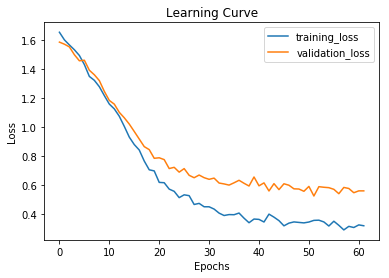

In [7]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

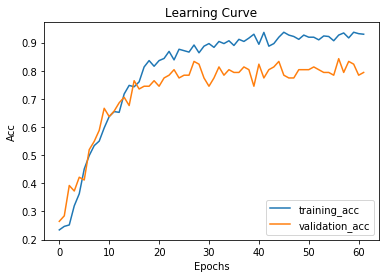

In [8]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [9]:
STEP_SIZE_VALID=validation_generator.samples//validation_generator.batch_size
model.evaluate_generator(generator=validation_generator,steps=STEP_SIZE_VALID)

[0.6023574223121008, 0.7604166666666666]

(299, 299, 3)
(1, 299, 299, 3)


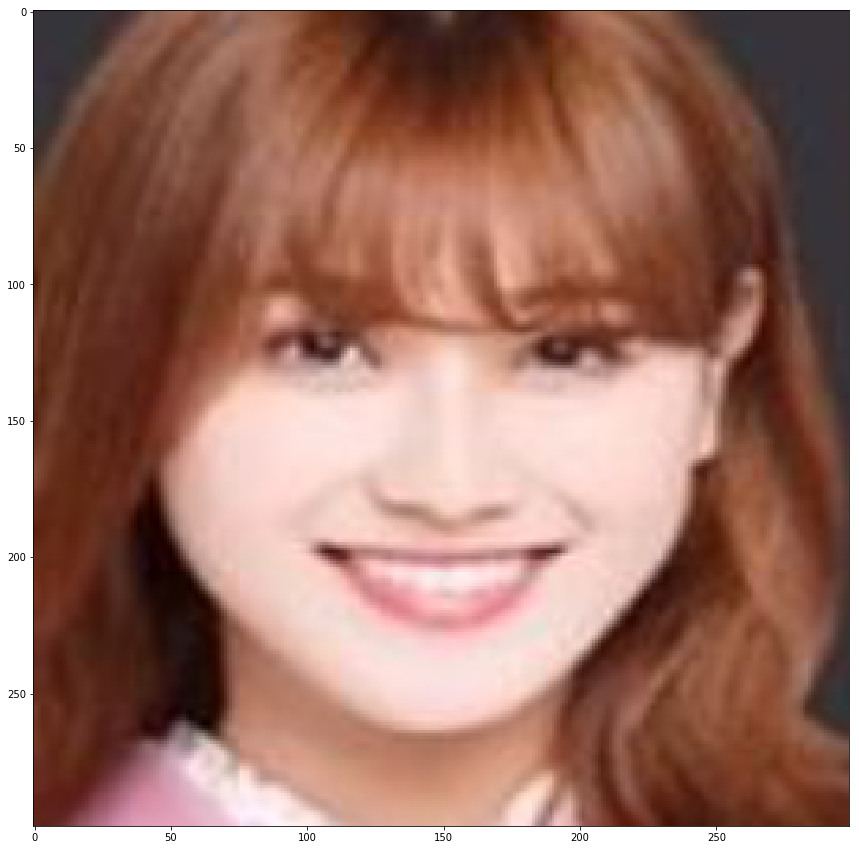

In [10]:
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

imgForTest = "training_set_aligned/akane/021.png"
img = cv2.imread(imgForTest)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print(img.shape)
img = img.reshape((1,) + img.shape)
print(img.shape)

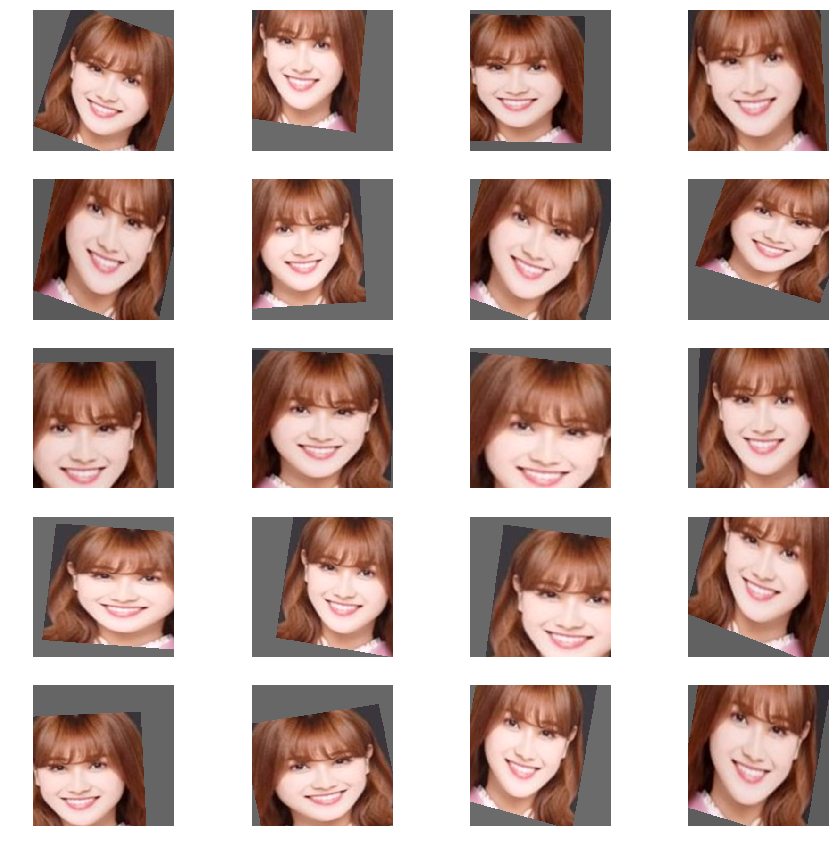

In [11]:
i = 0
for batch in train_datagen.flow(img, batch_size=10,save_to_dir="augmentation/", save_prefix="akane", save_format="png"):
    plt.subplot(5,4,1 + i)
    plt.axis("off")
    augImage = batch[0]
    augImage = augImage.astype("float32")
    #augImage /= 255
    plt.imshow(augImage)
    i += 1
    if i > 19:
        break

In [12]:
for layer in model.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv1_bn
block1_conv1_act
block1_conv2
block1_conv2_bn
block1_conv2_act
block2_sepconv1
block2_sepconv1_bn
block2_sepconv2_act
block2_sepconv2
block2_sepconv2_bn
conv2d_1
block2_pool
batch_normalization_1
add_1
block3_sepconv1_act
block3_sepconv1
block3_sepconv1_bn
block3_sepconv2_act
block3_sepconv2
block3_sepconv2_bn
conv2d_2
block3_pool
batch_normalization_2
add_2
block4_sepconv1_act
block4_sepconv1
block4_sepconv1_bn
block4_sepconv2_act
block4_sepconv2
block4_sepconv2_bn
conv2d_3
block4_pool
batch_normalization_3
add_3
block5_sepconv1_act
block5_sepconv1
block5_sepconv1_bn
block5_sepconv2_act
block5_sepconv2
block5_sepconv2_bn
block5_sepconv3_act
block5_sepconv3
block5_sepconv3_bn
add_4
block6_sepconv1_act
block6_sepconv1
block6_sepconv1_bn
block6_sepconv2_act
block6_sepconv2
block6_sepconv2_bn
block6_sepconv3_act
block6_sepconv3
block6_sepconv3_bn
add_5
block7_sepconv1_act
block7_sepconv1
block7_sepconv1_bn
block7_sepconv2_act
block7_sepconv2
block7_sep

In [13]:
import numpy as np

#from tensorflow.keras.models import Model
#from keras.models import Model
from keras import backend as K

import utils
from model import get_model
from vis import conv_output, conv_filter, output_heatmap

layer_name = 'conv2d_1 '
last_conv_layer = 'conv2d_4'

img_path = 'training_set_aligned/akane/023.png'
model_1, preprocess_input = get_model('xception')
img, pimg = utils.read_img(img_path, preprocess_input, (299, 299))
#model.summary()

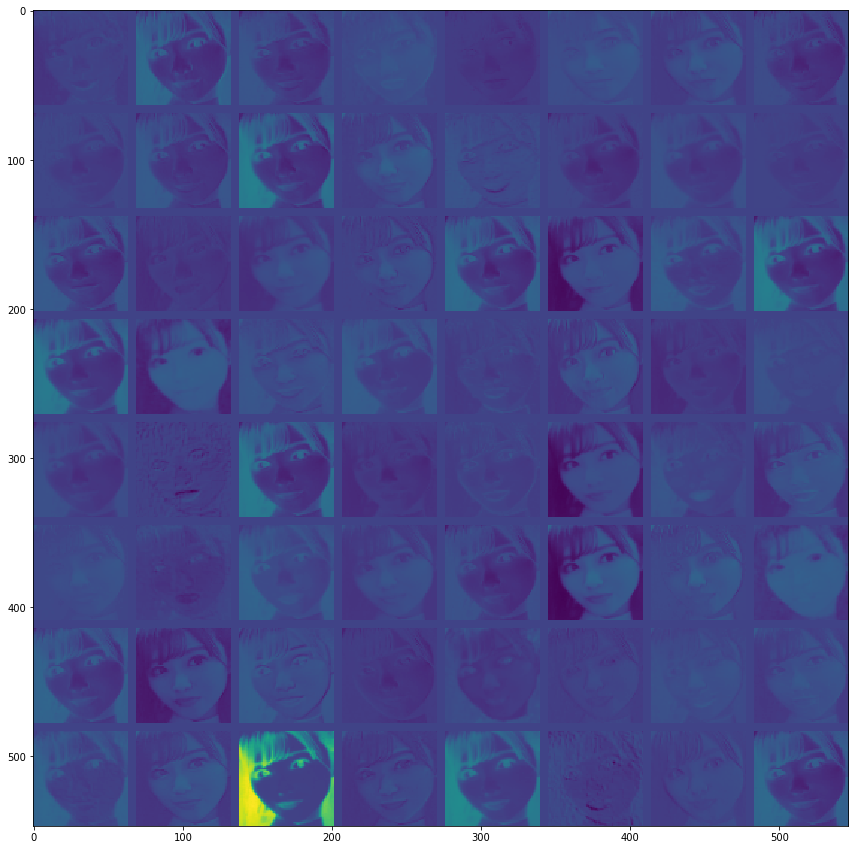

In [14]:
layer_name = 'conv2d_1'
cout = conv_output(model, layer_name, pimg)
utils.vis_conv(cout, 8, layer_name, 'conv')

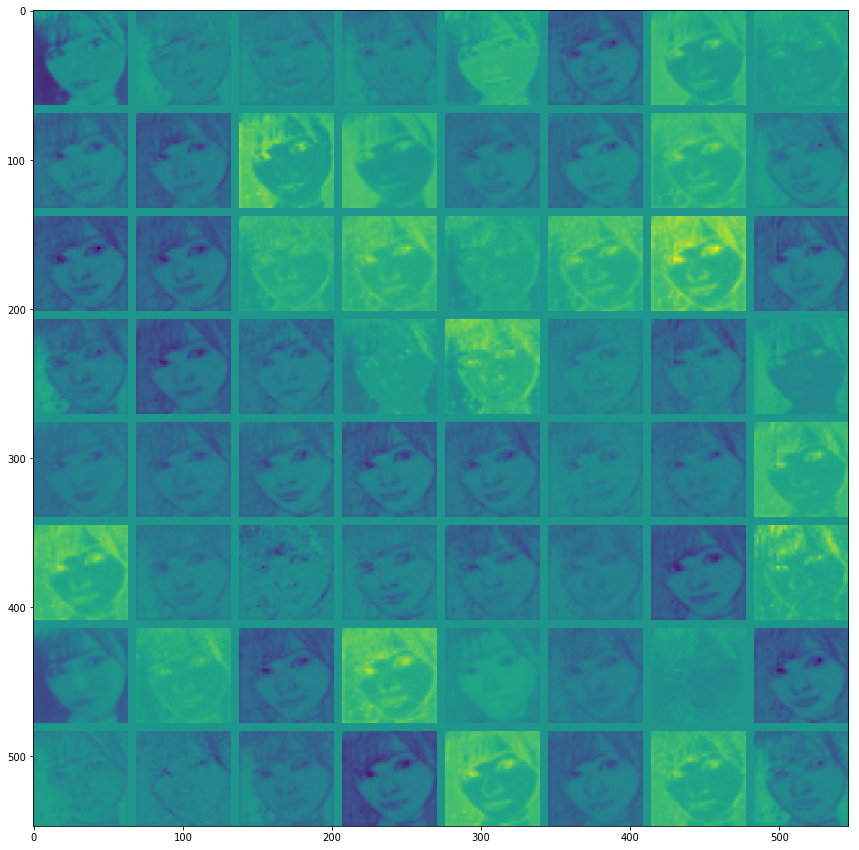

In [15]:
layer_name = 'conv2d_2'
cout = conv_output(model, layer_name, pimg)
utils.vis_conv(cout, 8, layer_name, 'conv')

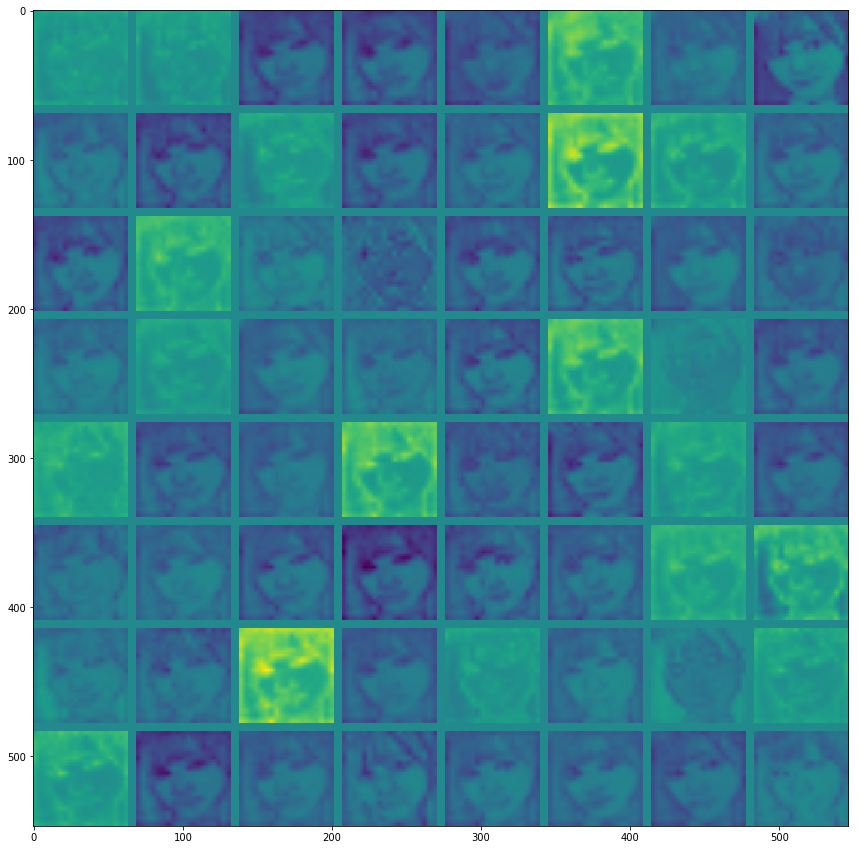

In [16]:
layer_name = 'conv2d_3'
cout = conv_output(model, layer_name, pimg)
utils.vis_conv(cout, 8, layer_name, 'conv')

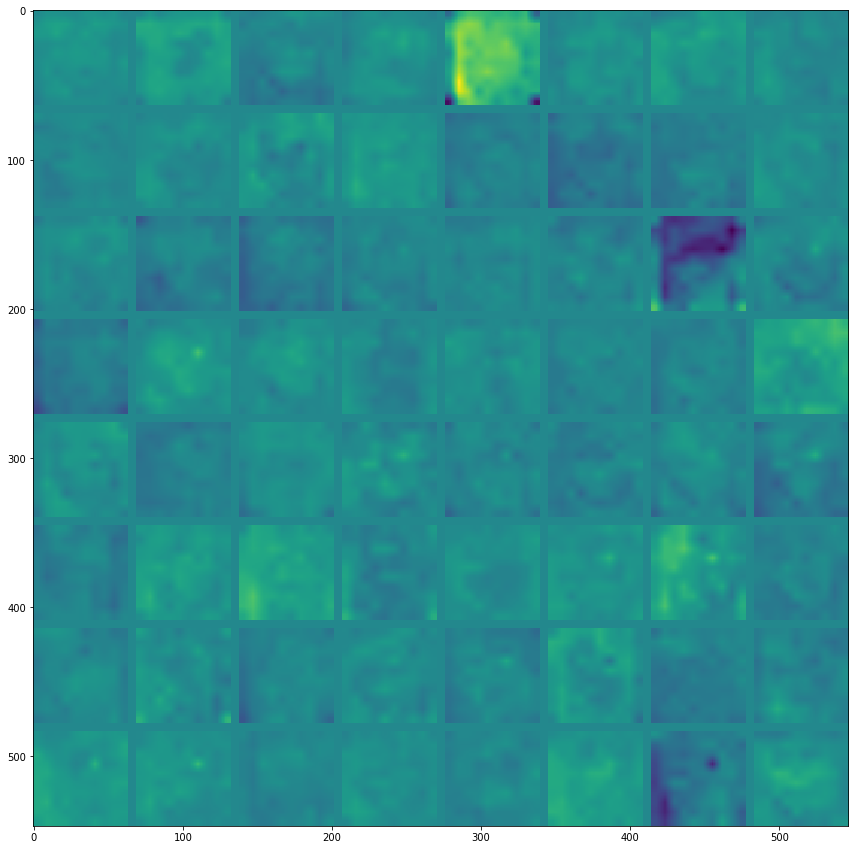

In [17]:
layer_name = 'conv2d_4'
#layer_name = 'block14_sepconv2'
cout = conv_output(model, layer_name, pimg)
utils.vis_conv(cout, 8, layer_name, 'conv')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


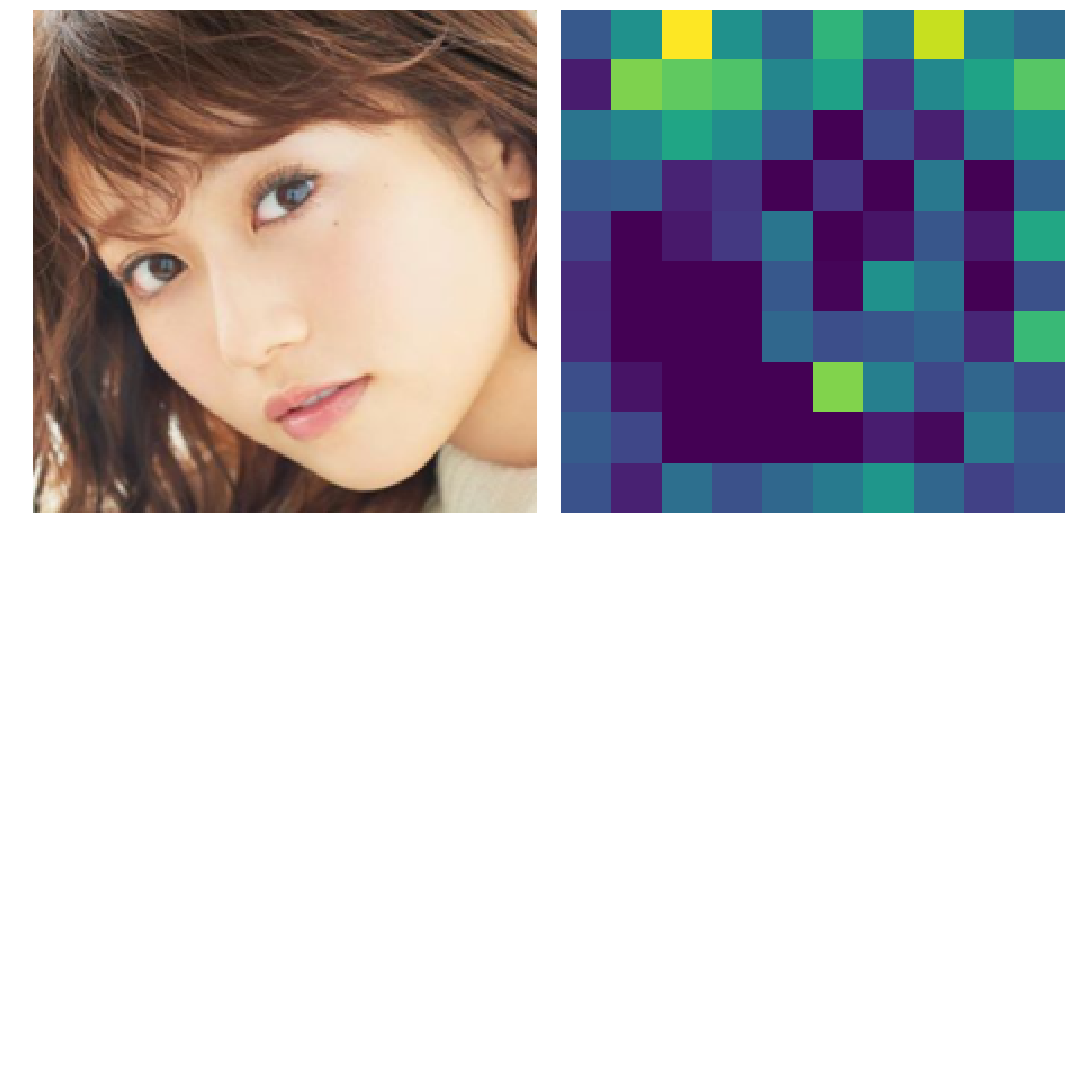

In [18]:
img_path = 'training_set_aligned/akane/031.png'
img, pimg = utils.read_img(img_path, preprocess_input, (299, 299))

last_conv_layer = 'conv2d_4'
heatmap = output_heatmap(model, last_conv_layer, pimg)
utils.vis_heatmap(img, heatmap)

import dlib

import mtcnn